# Figures for section 1: Introduction

-8.44


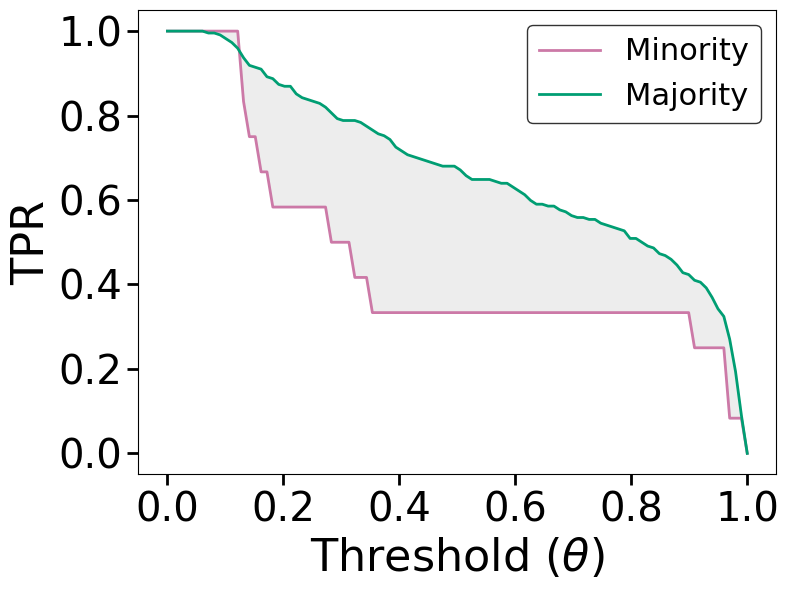

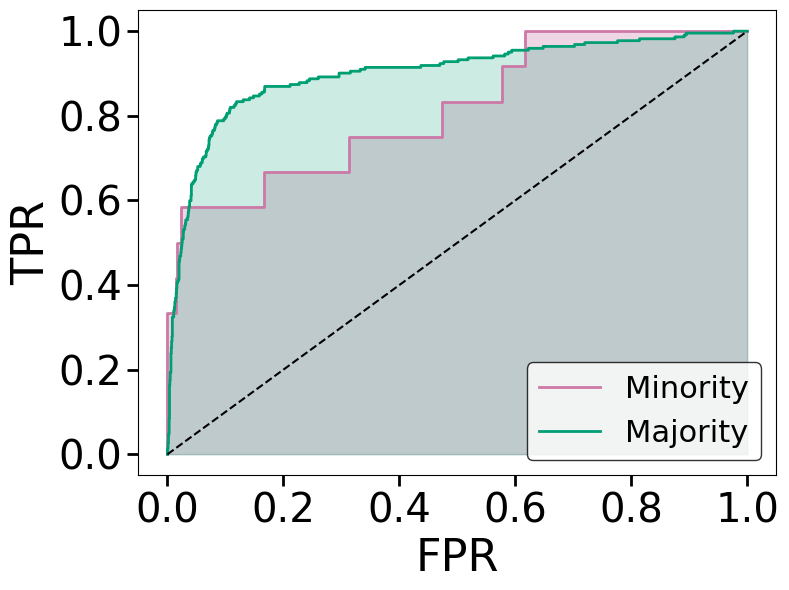

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os  
import pandas as pd
from fairness import * 
from sklearn.metrics import roc_curve, roc_auc_score 


# Load sensitive attribute dictionary for analyzing fairness
with open('saved_params/sens_attr_dict_test.pkl', 'rb') as f:
    sens_attr_dict = pickle.load(f)

# Define model and dataset names for specific analysis
MODEL = 'HierMatcher'
DATASET = 'Amazon-Google'


model = MODEL
dataset = DATASET
sens_attr = sens_attr_dict[dataset]

path_base = os.getcwd()

# Load test data and prediction scores
df_test = pd.read_csv(path_base + '/DataDir/' + dataset + '/test.csv')
scores_test = pd.read_csv(path_base + '/scores/' + dataset + '_' + model + '/score_test.csv')


# Identify the prediction column (either probability or binary)
for x in list(scores_test.columns):
    if len(np.unique(scores_test[x])) > 2:
        prob_test = scores_test[x]  # Probability scores
    else:
        y_test = scores_test[x]     # Binary labels

y_true = np.array(y_test)
score = np.array(prob_test)
score_g1 = score[sens_attr == 1]
score_g2 = score[sens_attr == 0]


# Initialize lists to hold fairness metrics calculated at different thresholds
E_opp__sens = []
E_opp__non_sens = []
E_odds_sens = []
E_odds__non_sens = []

# Define the threshold range for analysis
start, end, step = 0, 1, 100
range = np.linspace(start, end, step)

# Calculate and store fairness metrics across different threshold values
for TH in range:
    # Generate predictions based on threshold
    y_pred = np.array([1 if score > TH else 0 for score in score])
    # Calculate additional fairness metrics
    additional_fairness_metrics = calculate_additional_fairness_metrics2(y_true, y_pred, sens_attr)
    # Extract and append specific fairness metrics
    E_opp__sens.append(additional_fairness_metrics[0]['e_opp__sens'])
    E_opp__non_sens.append(additional_fairness_metrics[0]['e_opp__non_sens'])
    E_odds_sens.append(additional_fairness_metrics[0]['e_odds_sens'])
    E_odds__non_sens.append(additional_fairness_metrics[0]['e_odds__non_sens'])

# Compute ROC curves and AUC scores for minority and majority groups
fpr1, tpr1, _ = roc_curve(y_true[sens_attr == 1], score_g1, drop_intermediate=False)
fpr2, tpr2, _ = roc_curve(y_true[sens_attr == 0], score_g2, drop_intermediate=False)
auc1 = roc_auc_score(y_true[sens_attr == 1], score_g1)  # AUC for minority group
auc2 = roc_auc_score(y_true[sens_attr == 0], score_g2)  # AUC for majority group

# Calculate disparity in true positive rates for Equal Opportunity comparison
EO_opps_dist = calc_DP_TPR(sens_attr, y_true, score)

# Define colors and styling for plots
minority_col, majority_col, green_color = "#FF5733", "#33AFFF", "#C7E9B4"
minority_col, majority_col, green_color = "#CC79A7", "#009E73", "#C7E9B4"
L, F, F_legend, F_title, size = 1.5, 28, 22, 32, (8, 6)

# Print AUC disparity percentage between minority and majority groups
print(round(100 * (auc1 - auc2), 2))

# Plot Equal Opportunity metrics across thresholds for each group
plt.figure(figsize=size)
plt.plot(range, E_opp__sens, label='Minority', color=minority_col, linewidth=2)
plt.plot(range, E_opp__non_sens, label='Majority', color=majority_col, linewidth=2)
plt.fill_between(range, E_opp__sens, E_opp__non_sens, color='#D3D3D3', alpha=0.4)
plt.xlabel('Threshold (' + r'$\theta$' + ')', fontsize=F_title)
plt.ylabel('TPR', fontsize=F_title)
plt.legend(fontsize=F_legend).get_frame().set_edgecolor('black')
plt.xticks(fontsize=F_title - 3)
plt.yticks(fontsize=F_title - 3)
plt.tick_params(axis='both', which='both', length=8, width=2)
plt.tight_layout()
plt.savefig('FIGURES/Intro_EQ_OPP.pdf')

# Plot ROC curves for minority and majority groups, with areas under the curves shaded
plt.figure(figsize=size)
plt.plot(fpr1, tpr1, label='Minority', color=minority_col, linewidth=2)
plt.plot(fpr2, tpr2, label='Majority', color=majority_col, linewidth=2)
plt.fill_between(fpr1, tpr1, color=minority_col, alpha=0.3)
plt.fill_between(fpr2, tpr2, color=majority_col, alpha=0.2)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Diagonal reference line for random classifier
plt.xlabel('FPR', fontsize=F_title)
plt.ylabel('TPR', fontsize=F_title)
plt.legend(fontsize=F_legend).get_frame().set_edgecolor('black')
plt.xticks(fontsize=F_title - 3)
plt.yticks(fontsize=F_title - 3)
plt.tick_params(axis='both', which='both', length=8, width=2)
plt.tight_layout()
plt.savefig('FIGURES/Intro_AUC.pdf')


# Figures for Section 2.3: Wasserstein Distance and Barycenter

/var/folders/6d/skl7zt150mq7s0bxj015f9cc0000gn/T/ipykernel_12191/2892432829.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('FIGURES/EMD_BG.pdf', bbox_inches='tight', pad_inches=0.1)
/var/folders/6d/skl7zt150mq7s0bxj015f9cc0000gn/T/ipykernel_12191/2892432829.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('FIGURES/EMD_BG.pdf', bbox_inches='tight', pad_inches=0.1)
/opt/homebrew/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


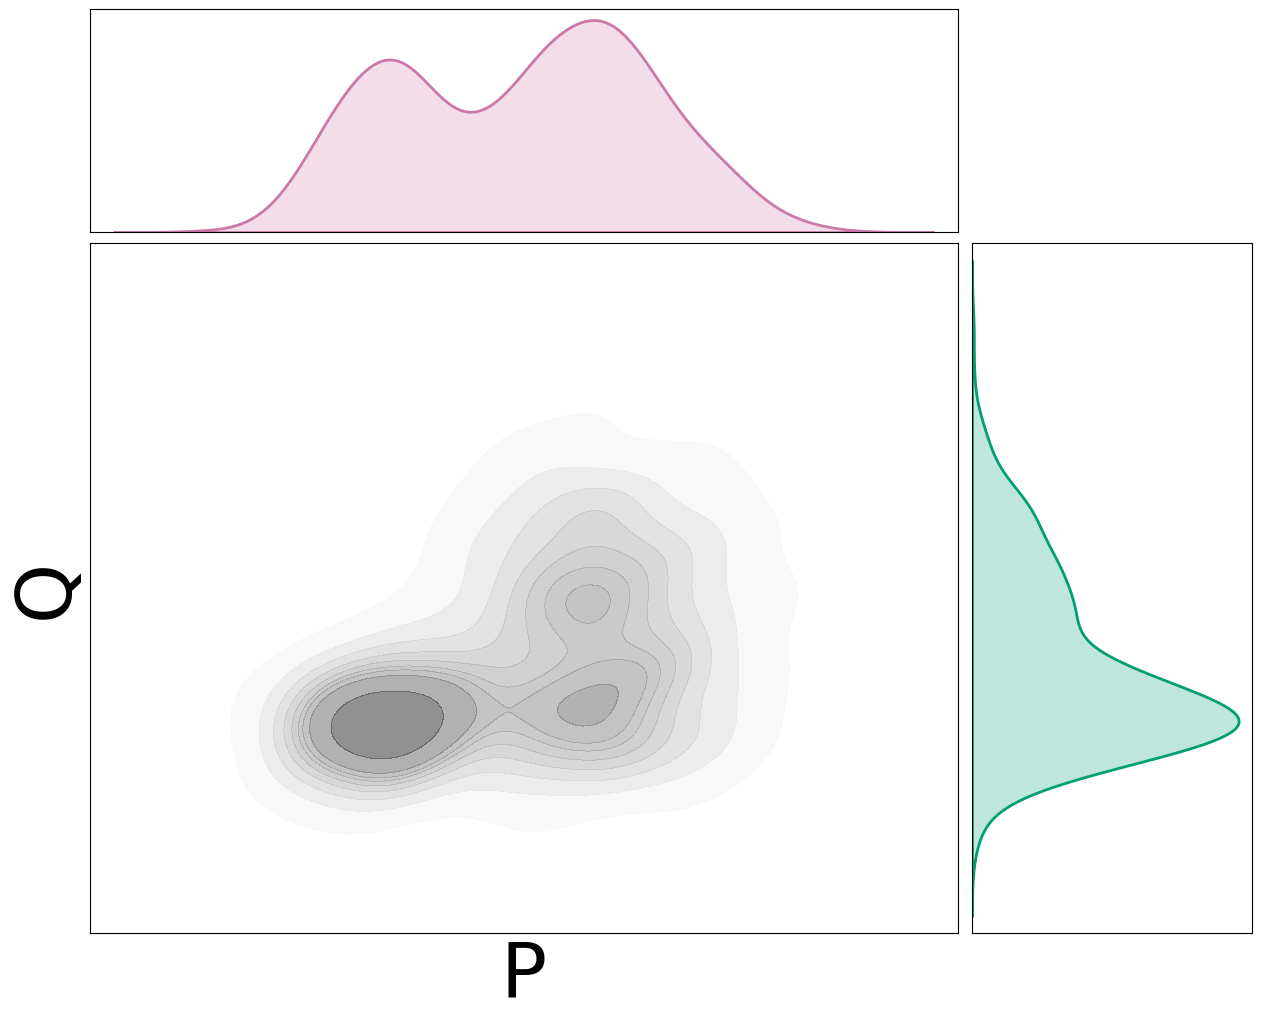

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate a mixture distribution for the x-axis, with two peaks to create asymmetry
x_mixture = np.concatenate([
    np.random.normal(-2, 1, 350),  # First peak of x-mix at -2, std dev 1
    np.random.normal(2, 1.5, 650)  # Second peak of x-mix at 2, std dev 1.5, with more points
])

# Generate a mixture distribution for the y-axis, with two peaks to create asymmetry
y_mixture = np.concatenate([
    np.random.normal(0, 0.8, 550),  # First peak of y-mix at 0, std dev 0.8
    np.random.normal(3, 2, 450)     # Second peak of y-mix at 3, std dev 2
])

# Initialize the figure and set layout options
fig = plt.figure(figsize=(15, 12), constrained_layout=True)

# Set up a grid for the main joint plot and the marginal histograms
grid = plt.GridSpec(4, 4, hspace=0.1/2, wspace=0.1/2)  # Reduced space between plots
main_ax = fig.add_subplot(grid[1:4, 0:3])  # Main joint plot area
x_hist_ax = fig.add_subplot(grid[0, 0:3], sharex=main_ax)  # Top histogram (x-axis)
y_hist_ax = fig.add_subplot(grid[1:4, 3], sharey=main_ax)  # Right histogram (y-axis)

# Plot joint KDE for combined x and y distributions on the main plot
sns.kdeplot(x=x_mixture, y=y_mixture, fill=True, cmap="gist_gray_r", ax=main_ax, alpha=0.5)

# Define colors for different components
minority_col, majority_col, green_color = "#CC79A7", "#009E73", "#C7E9B4"

# Plot marginal KDE for x-axis distribution
sns.kdeplot(x=x_mixture, ax=x_hist_ax, fill=True, linewidth=2, color="#CC79A7")

# Plot marginal KDE for y-axis distribution
sns.kdeplot(y=y_mixture, ax=y_hist_ax, fill=True, linewidth=2, color="#009E73")

# Apply rotation and mirroring on the right marginal plot for visual symmetry
y_hist_ax.invert_xaxis()  # Invert once horizontally
y_hist_ax.invert_xaxis()  # Invert again to complete the rotation

# Hide tick labels and y-axis labels on marginal axes to keep the appearance clean
x_hist_ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
y_hist_ax.tick_params(axis="y", which="both", left=False, labelleft=False)
x_hist_ax.set_ylabel("")  # Remove y-axis label for top marginal plot
x_hist_ax.set_xlabel("")  # Remove x-axis label for top marginal plot
y_hist_ax.set_ylabel("")  # Remove y-axis label for right marginal plot
y_hist_ax.set_xlabel("")  # Remove x-axis label for right marginal plot

# Additional tick adjustments for clarity
x_hist_ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
y_hist_ax.tick_params(axis="y", which="both", bottom=False, labelbottom=False)
x_hist_ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
y_hist_ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
y_hist_ax.tick_params(axis="y", which="both", bottom=False, labelbottom=False)
x_hist_ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# Ensure label consistency across marginal plots
x_hist_ax.set_ylabel("")  # Remove y-axis label for top marginal plot
y_hist_ax.set_ylabel("")  # Remove y-axis label for right marginal plot

# Remove all ticks for main and marginal plots for cleaner presentation
main_ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
x_hist_ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
y_hist_ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

# Set main plot axis labels
main_ax.set_xlabel('P', fontsize=55)
main_ax.set_ylabel('Q', fontsize=55)

# Save the final figure to a file
plt.savefig('FIGURES/EMD_BG.pdf', bbox_inches='tight', pad_inches=0.1)


/opt/homebrew/lib/python3.12/site-packages/ot/bregman/_barycenter.py:209: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


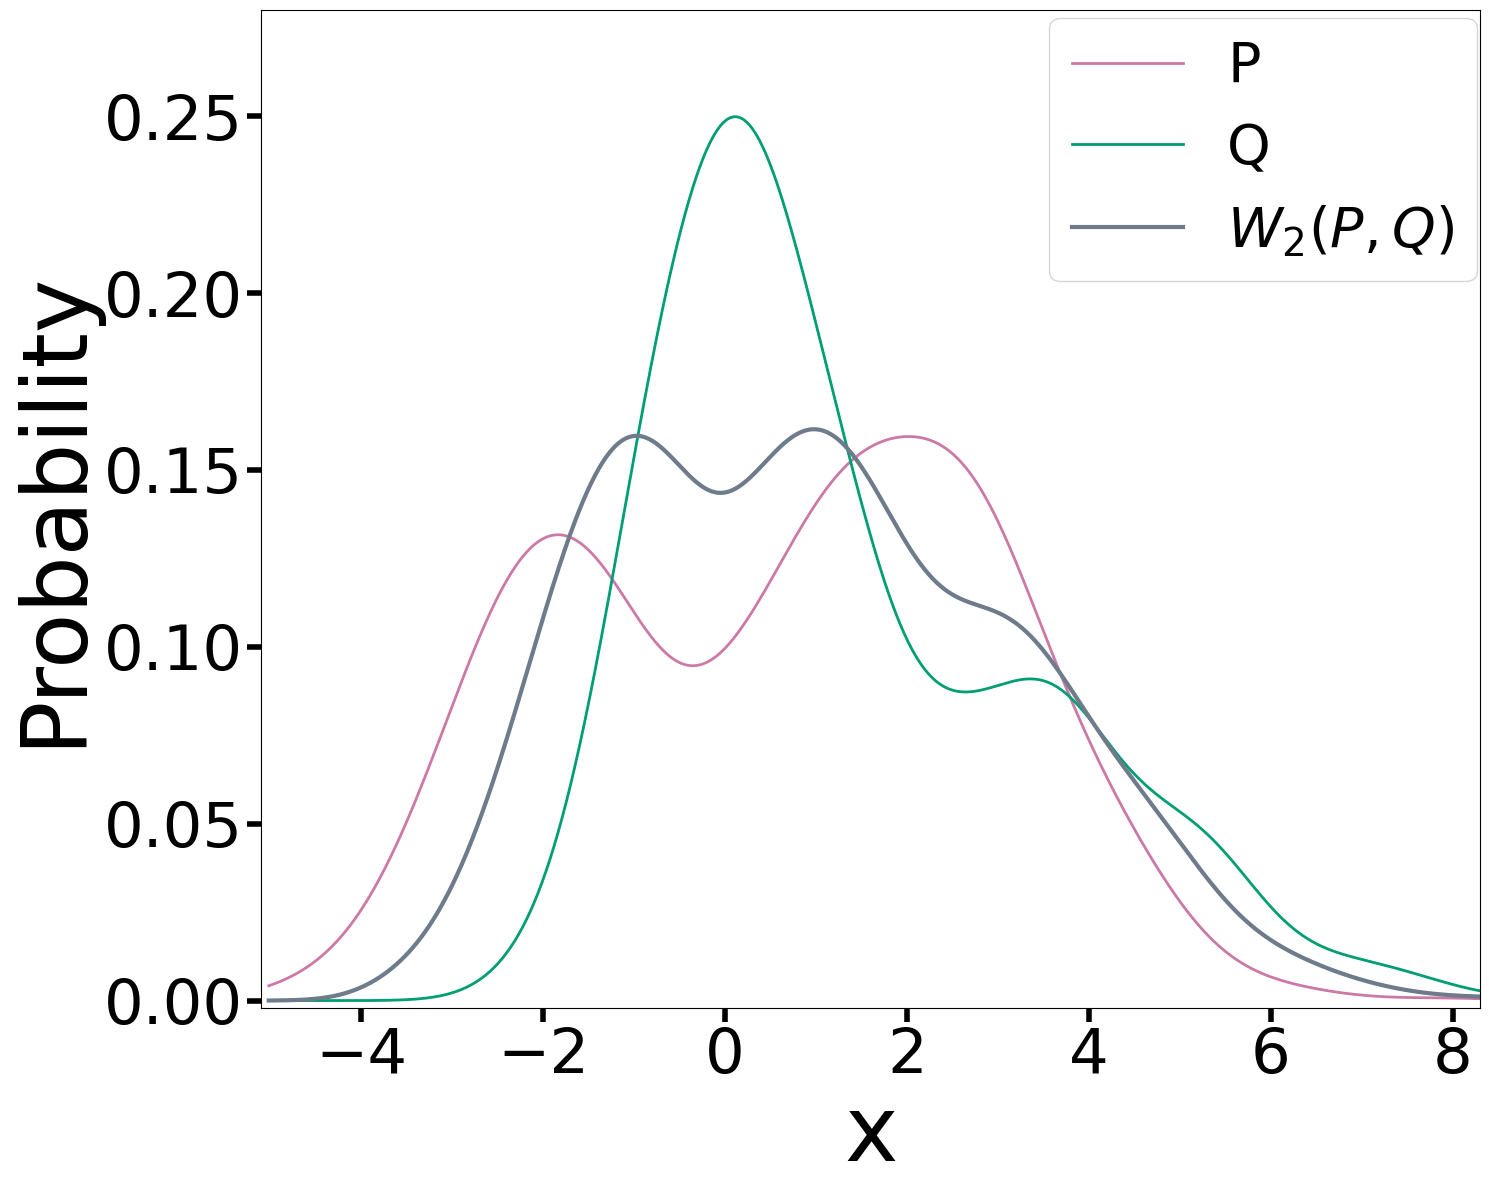

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import ot

# Generate mixture distribution for x-axis with distinct peaks
x_mixture = np.concatenate([
    np.random.normal(-2, 1, 350),  # First peak centered at -2, std dev of 1
    np.random.normal(2, 1.5, 650)  # Second peak centered at 2, std dev of 1.5
])

# Generate mixture distribution for y-axis with distinct peaks
y_mixture = np.concatenate([
    np.random.normal(0, 0.8, 550),  # First peak centered at 0, std dev of 0.8
    np.random.normal(3, 2, 450)     # Second peak centered at 3, std dev of 2
])

# Define the grid for KDE estimation based on the range of x and y values
x_vals = np.linspace(min(x_mixture.min(), y_mixture.min()), max(x_mixture.max(), y_mixture.max()), 1000)

# Calculate KDE values for x_mixture distribution
kde_x = gaussian_kde(x_mixture)
y_vals = kde_x(x_vals)

# Calculate KDE values for y_mixture distribution
kde_y = gaussian_kde(y_mixture)
y_vals2 = kde_y(x_vals)

# Define the weighting factor for the barycenter calculation, with alpha between 0 and 1
alpha = 0.5  # Equal weighting for P and Q distributions
weights = np.array([1 - alpha, alpha])

# Stack the distributions into matrix A for barycenter calculation
A = np.vstack((y_vals, y_vals2)).T
n_distributions = A.shape[1]

# Define the loss matrix for optimal transport and normalize it
M = ot.utils.dist0(len(x_vals))
M /= M.max()  # Normalize to maximum value for numerical stability

# Compute the Wasserstein barycenter with a regularization parameter
reg = 1e-3  # Regularization parameter for computational stability
bary_wass = ot.bregman.barycenter(A, M, reg, weights)

# Plot the original distributions and their Wasserstein barycenter
plt.figure(figsize=(15, 12), tight_layout=True)
plt.plot(x_vals, A[:, 0], color='#CC79A7', label='P', linewidth=2)  # Plot for distribution P
plt.plot(x_vals, A[:, 1], color='#009E73', label='Q', linewidth=2)  # Plot for distribution Q
plt.plot(x_vals, bary_wass, color='#6E7B8B', label=r'$W_2(P,Q)$', linewidth=3)  # Plot barycenter

# Customize legend and place it in the top-right corner
plt.legend(fontsize=40, loc='upper right', bbox_to_anchor=(1.02, 1.02))

# Adjust tick and label sizes for clarity
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.tick_params(axis='both', which='both', length=10, width=4)

# Set axis limits for x and y
plt.ylim([-0.002, 0.28])
plt.xlim([-5.1, 8.3])

# Label the axes
plt.xlabel('x', fontsize=65)
plt.ylabel('Probability', fontsize=65)

# Save the plot to a file with tight bounding box
plt.savefig('FIGURES/barry.pdf', bbox_inches='tight', pad_inches=0.1)

# Display the plot
plt.show()
